In [10]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import censusdata
import re

censuskey = '7b3e8a6afe58867abcf5aecad26845d802115f1f'

In [11]:
#Define Funtions

#Funcion For NonDigit Removing Characters from Row - Used for Extracting GEOID
def remove_chars(s):
    clean = int(re.sub('[^0-9]+', '', str(s))[-11:])
    return clean

#Function to get census data according to requirements
def getcensustables(table):
    tablename = 'data_' + table
    print(f'Downloading {table}')
    
    # Set requirements to pull from Census API
    
    variablestopull = allvariablescsv.loc[allvariablescsv['Group']==table]['Name'].tolist()
    listofcounties = ['121', '089']
    yearstopull = range(2015,2018,1)

    #Pull Census Data according to requirement above
    atlantadata = pd.DataFrame()

    for year in yearstopull:
        for county in listofcounties:

            newdata = censusdata.download('acs5', year, censusdata.censusgeo([('state', '13'), ('county', county), ('tract', '*')]),variablestopull,censuskey)
            type(newdata)
            newdata['YEAR'] = year
            atlantadata = atlantadata.append(newdata)

    #Rename Column Headings from Code to Text
    for variable in variablestopull:
        #print(variable)
        renamevar1 = allvariablescsv.loc[allvariablescsv['Name']==variable]['Label'].iloc[0]
        renamevar2 = allvariablescsv.loc[allvariablescsv['Name']==variable]['Concept'].iloc[0]
        renamevar = renamevar2 + '_'+ renamevar1
        #print(renamevar)
        atlantadata = atlantadata.rename(columns={variable: renamevar})

    #Transform Index to create GeoID

    #Create GeoID Column
    atlantadata['Name2'] = atlantadata.index
    atlantadata['GEOID'] = atlantadata['Name2'].apply(remove_chars)
    atlantadata.drop(columns=['Name2'], inplace=True)
    
    #Only Keep Atlanta Census Tracts(Geocodes)
    finaldata = atlantageocodes.merge(atlantadata, how='left', on='GEOID')
    
    finaldata = finaldata.dropna(axis=0, how='any')
    
    return finaldata

In [12]:
#Code Begins here

#Tables to Load from data/tablestopull.csv
tablestoloadcsv = pd.read_csv('data/tablestopull.csv')
tablestoload = tablestoloadcsv['Tables'].tolist()

#Uncommnent Line below to override csv
#tablestoload = ['B19013','B01003','B11001', 'B25064', 'B25074','B25063', 'B25061','B25056','B00002','B25001','B25122']

#Allvariables Table to get table detail
allvariablescsv = pd.read_csv('data/allvariables.csv')

#Atlanta Geo Codes Table to filter to city of atlanta only 
atlantageocodes = pd.read_csv('data/atlantageocodes.csv')

#Create dictionary with each cleaned table as an entry
alltables = dict()  


#Script will attempt to load tables from data folder first, otherwise download them
#Wont work for tables over 50 variables(need to fix)
for table in tablestoload:
    try:
        data = pd.read_csv('data/' + table + '.csv')
        alltables[table] = data
        print(f'Loading {table}')
    except:
        data = getcensustables(table)
        alltables[table] = data
        data.to_csv('data/' + table + '.csv')
        
        

Loading B19013
Loading B01003
Loading B11001
Loading B25064
Loading B25074
Loading B25063
Loading B25061
Loading B25056
Loading B00002
Loading B25001
Loading B25122


In [28]:
#Pull HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS and group by year
percentrentbyincome = alltables['B25074']


display(percentrentbyincome) ###eg for class


percentrentbyincome = percentrentbyincome.groupby('YEAR').sum()
percentrentbyincome = percentrentbyincome.transpose()


#Split index into variables
percentrentbyincome['YEAR'] = percentrentbyincome.index
split1 = percentrentbyincome['YEAR'].str.split('PAST 12 MONTHS_Estimate!!Total!!', expand=True)
split2 = split1[1].str.split('!!', expand=True)

percentrentbyincome['Income'] = split2[0]
percentrentbyincome['Rent as % of Income'] = split2[1]

percentrentbyincome.drop(columns='YEAR')


#Set years to loop through
years = [2014.0,2015.0,2016.0,2017.0]

percentrentbyincome2 = percentrentbyincome.copy()


for year in years:

    print(year)
    percentrentbyincome = percentrentbyincome2[[year,'Income','Rent as % of Income']]

    #display(percentrentbyincome)
    percentrentbyincome = percentrentbyincome.dropna(axis=0, how='any')
    #display(percentrentbyincome)
    # display(percentrentbyincome.pivot(index=percentrentbyincome['Income'], columns=percentrentbyincome['Rent Change'], values=percentrentbyincome[2012.0]))

    percentrentbyincomepv = pd.crosstab(index=percentrentbyincome.iloc[:,1], columns=percentrentbyincome.iloc[:,2], 
                      values=percentrentbyincome.iloc[:,0], aggfunc='mean')

    percentrentbyincomepv['TotalHHs'] = percentrentbyincomepv.sum(axis = 1, skipna = True) 

    #percentrentbyincomepv = percentrentbyincomepv.div(percentrentbyincomepv.TotalHHs, axis=0)*100

    display(percentrentbyincomepv)

Unnamed: 0        GEOID  \
0             0  13121006601   
1             1  13121006601   
2             2  13121006601   
3             3  13121006601   
4             4  13121006700   
5             5  13121006700   
6             6  13121006700   
7             7  13121006700   
8             8  13121009300   
9             9  13121009300   
10           10  13121009300   
11           11  13121009300   
12           12  13121009402   
13           13  13121009402   
14           14  13121009402   
15           15  13121009402   
16           17  13089023700   
17           18  13089023700   
18           19  13089023700   
19           20  13089023700   
20           21  13121001300   
21           22  13121001300   
22           23  13121001300   
23           24  13121001300   
24           25  13121001400   
25           26  13121001400   
26           27  13121001400   
27           28  13121001400   
28           29  13121001800   
29           30  13121001800   
..          ...          ...   
482         483  13121005800   
483         484  13121005800   
484         485  13121006500   
485         486  13121006500   
486         487  13121006500   
487         488  13121006500   
488         489  13121008602   
489         490  13121008602   
490         491  13121008602   
491         492  13121008602   
492         493  13121008800   
493         494  13121008800   
494         495  13121008800   
495         496  13121008800   
496         497  13121009200   
497         498  13121009200   
498         499  13121009200   
499         500  13121009200   
500         501  13121007500   
501         502  13121007500   
502         503  13121007500   
503         504  13121007500   
504         505  13121008101   
505         506  13121008101   
506         507  13121008101   
507         508  13121008101   
508         509  13121006000   
509         510  13121006000   
510         511  13121006000   
511         512  13121006000   

     HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS_Estimate!!Total!!Less than $10,000  \
0                                                  118                                                                             
1                                                  100                                                                             
2                                                  128                                                                             
3                                                  108                                                                             
4                                                  302                                                                             
5                                                  226                                                                             
6                                                  197                                                                             
7                                                  217                                                                             
8                                                   85                                                                             
9                                                   59                                                                             
10                                                 196                                                                             
11                                                 190                                                                             
12                                                  75                                                                             
13                                                 112                                                                             
14                                      

2014.0


Rent as % of Income  20.0 to 24.9 percent  25.0 to 29.9 percent  \
Income                                                            
$10,000 to $19,999                  630.0                1165.0   
$100,000 or more                    784.0                 204.0   
$20,000 to $34,999                  747.0                1905.0   
$35,000 to $49,999                 2472.0                3767.0   
$50,000 to $74,999                 4854.0                2904.0   
$75,000 to $99,999                 1814.0                 673.0   
Less than $10,000                   321.0                1044.0   

Rent as % of Income  30.0 to 34.9 percent  35.0 to 39.9 percent  \
Income                                                            
$10,000 to $19,999                  765.0                 555.0   
$100,000 or more                     70.0                  43.0   
$20,000 to $34,999                 2666.0                3137.0   
$35,000 to $49,999                 2849.0                1388.0   
$50,000 to $74,999                 1346.0                 517.0   
$75,000 to $99,999                  216.0                  95.0   
Less than $10,000                   583.0                 392.0   

Rent as % of Income  40.0 to 49.9 percent  50.0 percent or more  \
Income                                                            
$10,000 to $19,999                 1741.0               10565.0   
$100,000 or more                    137.0                  60.0   
$20,000 to $34,999                 3931.0                5108.0   
$35,000 to $49,999                 1115.0                 377.0   
$50,000 to $74,999                  521.0                 147.0   
$75,000 to $99,999                   14.0                  39.0   
Less than $10,000                   578.0               11012.0   

Rent as % of Income  Less than 20.0 percent  TotalHHs  
Income                                                 
$10,000 to $19,999                    942.0   16363.0  
$100,000 or more                     8901.0   10199.0  
$20,000 to $34,999                    848.0   18342.0  
$35,000 to $49,999                    989.0   12957.0  
$50,000 to $74,999                   4176.0   14465.0  
$75,000 to $99,999                   4922.0    7773.0  
Less than $10,000                     406.0   14336.0

2015.0


Rent as % of Income  20.0 to 24.9 percent  25.0 to 29.9 percent  \
Income                                                            
$10,000 to $19,999                  586.0                1117.0   
$100,000 or more                    801.0                 285.0   
$20,000 to $34,999                  681.0                1786.0   
$35,000 to $49,999                 2700.0                4255.0   
$50,000 to $74,999                 5113.0                3019.0   
$75,000 to $99,999                 1993.0                 804.0   
Less than $10,000                   328.0                1007.0   

Rent as % of Income  30.0 to 34.9 percent  35.0 to 39.9 percent  \
Income                                                            
$10,000 to $19,999                  728.0                 578.0   
$100,000 or more                     73.0                  64.0   
$20,000 to $34,999                 2758.0                3046.0   
$35,000 to $49,999                 2755.0                1593.0   
$50,000 to $74,999                 1447.0                 601.0   
$75,000 to $99,999                  164.0                 155.0   
Less than $10,000                   450.0                 326.0   

Rent as % of Income  40.0 to 49.9 percent  50.0 percent or more  \
Income                                                            
$10,000 to $19,999                 1712.0               10799.0   
$100,000 or more                    124.0                  52.0   
$20,000 to $34,999                 4197.0                4917.0   
$35,000 to $49,999                 1197.0                 420.0   
$50,000 to $74,999                  484.0                 121.0   
$75,000 to $99,999                   33.0                  39.0   
Less than $10,000                   637.0               10849.0   

Rent as % of Income  Less than 20.0 percent  TotalHHs  
Income                                                 
$10,000 to $19,999                    856.0   16376.0  
$100,000 or more                     9950.0   11349.0  
$20,000 to $34,999                    740.0   18125.0  
$35,000 to $49,999                   1193.0   14113.0  
$50,000 to $74,999                   4611.0   15396.0  
$75,000 to $99,999                   5138.0    8326.0  
Less than $10,000                     405.0   14002.0

2016.0


Rent as % of Income  20.0 to 24.9 percent  25.0 to 29.9 percent  \
Income                                                            
$10,000 to $19,999                  824.0                1193.0   
$100,000 or more                   1073.0                 447.0   
$20,000 to $34,999                  618.0                1970.0   
$35,000 to $49,999                 2523.0                4172.0   
$50,000 to $74,999                 5336.0                3562.0   
$75,000 to $99,999                 2381.0                 792.0   
Less than $10,000                   279.0                 831.0   

Rent as % of Income  30.0 to 34.9 percent  35.0 to 39.9 percent  \
Income                                                            
$10,000 to $19,999                  800.0                 625.0   
$100,000 or more                     40.0                  57.0   
$20,000 to $34,999                 2862.0                2801.0   
$35,000 to $49,999                 2960.0                1687.0   
$50,000 to $74,999                 1539.0                 818.0   
$75,000 to $99,999                  280.0                 173.0   
Less than $10,000                   649.0                 200.0   

Rent as % of Income  40.0 to 49.9 percent  50.0 percent or more  \
Income                                                            
$10,000 to $19,999                 1796.0               10923.0   
$100,000 or more                     52.0                   0.0   
$20,000 to $34,999                 4583.0                4945.0   
$35,000 to $49,999                 1414.0                 699.0   
$50,000 to $74,999                  485.0                 150.0   
$75,000 to $99,999                   47.0                   1.0   
Less than $10,000                   595.0               10093.0   

Rent as % of Income  Less than 20.0 percent  TotalHHs  
Income                                                 
$10,000 to $19,999                    803.0   16964.0  
$100,000 or more                    10884.0   12553.0  
$20,000 to $34,999                    865.0   18644.0  
$35,000 to $49,999                   1019.0   14474.0  
$50,000 to $74,999                   4389.0   16279.0  
$75,000 to $99,999                   4944.0    8618.0  
Less than $10,000                     440.0   13087.0

2017.0


Rent as % of Income  20.0 to 24.9 percent  25.0 to 29.9 percent  \
Income                                                            
$10,000 to $19,999                  882.0                1241.0   
$100,000 or more                   1374.0                 491.0   
$20,000 to $34,999                  665.0                1637.0   
$35,000 to $49,999                 2332.0                4086.0   
$50,000 to $74,999                 5172.0                3830.0   
$75,000 to $99,999                 2841.0                1116.0   
Less than $10,000                   421.0                 897.0   

Rent as % of Income  30.0 to 34.9 percent  35.0 to 39.9 percent  \
Income                                                            
$10,000 to $19,999                  806.0                 468.0   
$100,000 or more                     80.0                  96.0   
$20,000 to $34,999                 2827.0                2743.0   
$35,000 to $49,999                 3172.0                1859.0   
$50,000 to $74,999                 1917.0                1159.0   
$75,000 to $99,999                  350.0                 200.0   
Less than $10,000                   536.0                 219.0   

Rent as % of Income  40.0 to 49.9 percent  50.0 percent or more  \
Income                                                            
$10,000 to $19,999                 1541.0               10248.0   
$100,000 or more                     65.0                   0.0   
$20,000 to $34,999                 4552.0                5058.0   
$35,000 to $49,999                 1560.0                 809.0   
$50,000 to $74,999                  624.0                 169.0   
$75,000 to $99,999                   52.0                  12.0   
Less than $10,000                   600.0                9194.0   

Rent as % of Income  Less than 20.0 percent  TotalHHs  
Income                                                 
$10,000 to $19,999                    921.0   16107.0  
$100,000 or more                    11984.0   14090.0  
$20,000 to $34,999                    972.0   18454.0  
$35,000 to $49,999                   1091.0   14909.0  
$50,000 to $74,999                   4113.0   16984.0  
$75,000 to $99,999                   4552.0    9123.0  
Less than $10,000                     400.0   12267.0

In [36]:
#Pull HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS and group by year

percentrentbyincome = alltables['B25074']
percentrentbyincome = percentrentbyincome.groupby('YEAR').sum() 
percentrentbyincome = percentrentbyincome.transpose()


#Split index into variables

percentrentbyincome['YEAR'] = percentrentbyincome.index
split1 = percentrentbyincome['YEAR'].str.split('PAST 12 MONTHS_Estimate!!Total!!', expand=True)
split2 = split1[1].str.split('!!', expand=True)
percentrentbyincome['Income'] = split2[0]
percentrentbyincome['Rent as % of Income'] = split2[1]
percentrentbyincome.drop(columns='YEAR')

#Set years of ACS5 to loop
years = [2015.0,2016.0,2017.0]


#Loop through the years of ACS5 to create a single organized dataframe
percentrentbyincomesum = pd.DataFrame()
percentrentbyincome2 = percentrentbyincome.copy()
percentrentbyincomesum2 = percentrentbyincomesum.copy()

for year in years:
    
    #Keep only relevant data points
    percentrentbyincome = percentrentbyincome2[[year,'Income','Rent as % of Income']]
    percentrentbyincome = percentrentbyincome.dropna(axis=0, how='any')
    
    #Create Matrix from Data
    percentrentbyincomepv = pd.crosstab(index=percentrentbyincome.iloc[:,1], columns=percentrentbyincome.iloc[:,2], 
                      values=percentrentbyincome.iloc[:,0], aggfunc='mean')
    percentrentbyincomepv['TotalHHs'] = percentrentbyincomepv.sum(axis = 1, skipna = True) 
    oldindex = percentrentbyincomepv.index.tolist()
    
    #Rebucket old census income ranges to our ranges
    percentrentbyincomepv.loc['Low Income'] = percentrentbyincomepv.loc['$10,000 to $19,999'] + percentrentbyincomepv.loc['Less than $10,000'] + percentrentbyincomepv.loc['$20,000 to $34,999']
    percentrentbyincomepv.loc['Moderate Income'] = percentrentbyincomepv.loc['$35,000 to $49,999'] + percentrentbyincomepv.loc['$50,000 to $74,999'] 
    percentrentbyincomepv.loc['High Income'] = percentrentbyincomepv.loc['$75,000 to $99,999'] + percentrentbyincomepv.loc['$100,000 or more'] 
    percentrentbyincomepv.drop(axis=0, index=oldindex, inplace=True)
    
    #Rebucket old census rent ranges to our ranges
    under30 = ['20.0 to 24.9 percent','25.0 to 29.9 percent','Less than 20.0 percent']
    over30 = ['30.0 to 34.9 percent','35.0 to 39.9 percent','40.0 to 49.9 percent', '50.0 percent or more']
    
    percentrentbyincomepv['Less than 30.0 percent'] = percentrentbyincomepv[under30].sum(axis=1)
    percentrentbyincomepv.drop(axis=1, columns=under30, inplace=True)
    
    percentrentbyincomepv['Over 30.0 percent'] = percentrentbyincomepv[over30].sum(axis=1)
    percentrentbyincomepv.drop(axis=1, columns=over30, inplace=True)
    
    #Add year column
    percentrentbyincomepv['YEAR'] = year
    
    #Append to final Dataframe
    percentrentbyincomesum = percentrentbyincomesum.append(percentrentbyincomepv)

#Reorder colums    
orderedcols = ['YEAR', 'Less than 30.0 percent', 'Over 30.0 percent', 'TotalHHs']
percentrentbyincomesum = percentrentbyincomesum.loc[:, orderedcols]



#percentrentbyincomepv = percentrentbyincomepv.div(percentrentbyincomepv.TotalHHs, axis=0)*100
#percentrentbyincomesum['Over 30% Percent'] = percentrentbyincomesum['Over 30.0 percent'].div(percentrentbyincomesum.TotalHHs, axis=0)
display(percentrentbyincomesum)

Rent as % of Income    YEAR  Less than 30.0 percent  Over 30.0 percent  \
Income                                                                   
Low Income           2015.0                  7506.0            40997.0   
Moderate Income      2015.0                 20891.0             8618.0   
High Income          2015.0                 18971.0              704.0   
Low Income           2016.0                  7823.0            40872.0   
Moderate Income      2016.0                 21001.0             9752.0   
High Income          2016.0                 20521.0              650.0   
Low Income           2017.0                  8036.0            38792.0   
Moderate Income      2017.0                 20624.0            11269.0   
High Income          2017.0                 22358.0              855.0   

Rent as % of Income  TotalHHs  
Income                         
Low Income            48503.0  
Moderate Income       29509.0  
High Income           19675.0  
Low Income            48695.0  
Moderate Income       30753.0  
High Income           21171.0  
Low Income            46828.0  
Moderate Income       31893.0  
High Income           23213.0

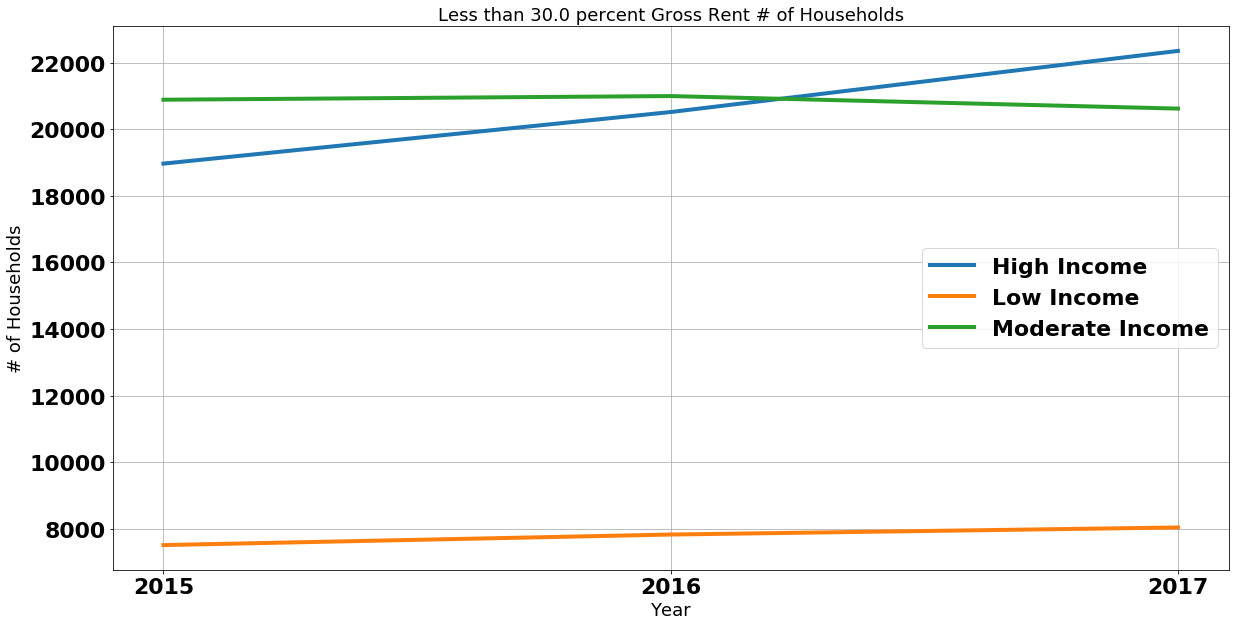

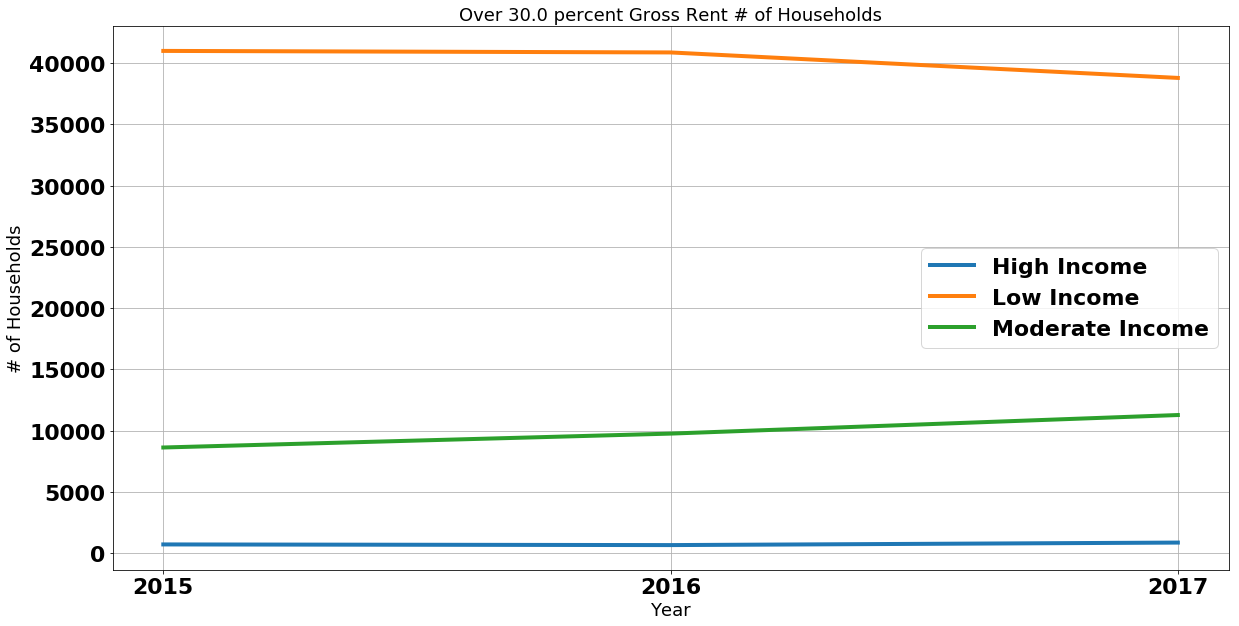

In [38]:
# Generate plot for Rent as % of Income

#Settings
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

#Variables
colors = {'Less than 30.0 percent':'red', 'Over 30.0 percent':'blue'}
groups = percentrentbyincomesum.groupby('Income')
percentbuckets = ['Less than 30.0 percent', 'Over 30.0 percent']
filename = '% Rent of Income, # of Households'

#Loop through each bucket and make chart
for bucket in percentbuckets:
    fig, ax = plt.subplots(figsize=(20, 10))
    for name, group in groups:

        #print(name)

        x = ['2015','2016','2017']
        y = percentrentbyincomesum.loc[percentrentbyincomesum.index==name, bucket]
        #print(percentbucket)
        plt.plot(x, y,color=colors.get(name), label=name,linewidth=4.0)
    ax.legend()
    ax.grid()
    # Create a title, x label, and y label for our chart

    plt.title(bucket + ' ' + "Gross Rent # of Households" , fontsize=18)
    plt.xlabel("Year", fontsize=18)
    plt.ylabel("# of Households", fontsize=18)


    #Save the Figure
    plt.savefig("images/" + filename + ' ' +bucket + ".png")
    plt.show()





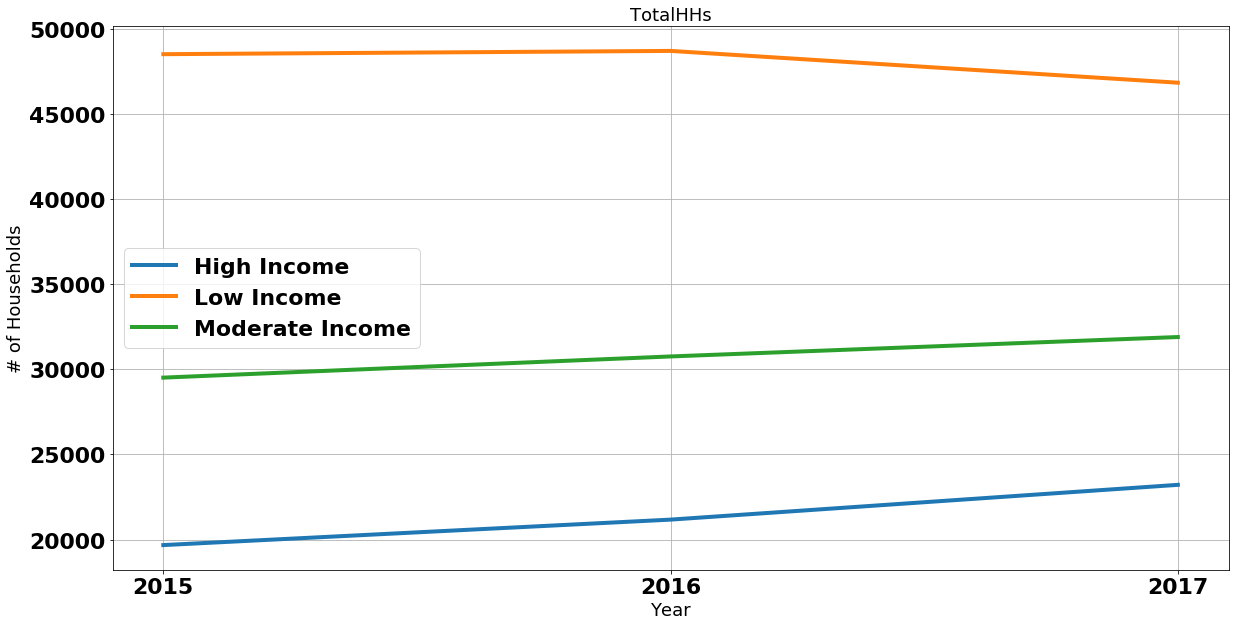

In [39]:
# Generate the Plot from percentrentbyincomesum for Total Households

#Drop irrelevant data
todrop = ['Less than 30.0 percent','Over 30.0 percent']
hhsbyincome = percentrentbyincomesum.drop(axis=1, columns=todrop)


# Settings
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)



#Variables
colors = {'TotalHHs':'blue', '30.0 to 34.9 percent':'blue', '35.0 to 39.9 percent':'green', '40.0 to 49.9 percent':'black', '50.0 percent or more':'pink'}
groups = hhsbyincome.groupby('Income')
filename = 'Total Households'

#Loop through all buckets
percentbuckets = ['TotalHHs']
for bucket in percentbuckets:
    fig, ax = plt.subplots(figsize=(20, 10))
    for name, group in groups:

        #print(name)

        x = ['2015','2016','2017']
        y = percentrentbyincomesum.loc[percentrentbyincomesum.index==name, bucket]
        #print(percentbucket)
        plt.plot(x, y,color=colors.get(name), label=name,linewidth=4.0)
    ax.legend()
    ax.grid()
        # Create a title, x label, and y label for our chart

    plt.title(bucket, fontsize=18)
    plt.xlabel("Year", fontsize=18)
    plt.ylabel("# of Households", fontsize=18)
    

    # Save the Figure
    plt.savefig("images/" + filename + ".png")
    
    #Display chart
    plt.show()




In [17]:
#Get Occupied Units by Rent Paid tables

occupiedunits = alltables['B25056']

#Group by year for simplicity
occupiedunits = occupiedunits.groupby('YEAR').sum()
occupiedunits = occupiedunits.transpose()


#Split index into relevant variables
occupiedunits['YEAR'] = occupiedunits.index
split1 = occupiedunits['YEAR'].str.split('!!', expand=True)
occupiedunits['Rent'] = split1[3]

#Backuptable for later
occupiedunitsog = occupiedunits.copy()

#Keep relevant results
occupiedunits.index = occupiedunits['Rent']
occupiedunits.drop(axis=1,columns=['Rent','YEAR'], inplace=True)
occupiedunits = occupiedunits.iloc[3:]

#Display table
display(occupiedunits)




YEAR                2015.0    2016.0    2017.0
Rent                                          
NaN               102110.0  104997.0  105867.0
Less than $100      2582.0    2470.0    2589.0
$100 to $149        1555.0    1638.0    1578.0
$150 to $199        2116.0    2077.0    1869.0
$200 to $249        2272.0    2246.0    2797.0
$250 to $299        1193.0    1350.0    1513.0
$300 to $349        1178.0    1307.0    1195.0
$350 to $399        1447.0    1359.0    1160.0
$400 to $449        1745.0    1836.0    1801.0
$450 to $499        2955.0    2637.0    2067.0
$500 to $549        4073.0    3976.0    3665.0
$550 to $599        5218.0    4687.0    4000.0
$600 to $649        5374.0    5358.0    5491.0
$650 to $699        6585.0    6464.0    5565.0
$700 to $749        5856.0    5602.0    5236.0
$750 to $799        6427.0    6614.0    5416.0
$800 to $899       11375.0   10842.0   10407.0
$900 to $999        8275.0    8867.0    8117.0
$1,000 to $1,249   15370.0   15886.0   17105.0
$1,250 to $1,499    7835.0    9073.0   10129.0
$1,500 to $1,999    5967.0    7439.0    9938.0
$2,000 to $2,499    1389.0    1742.0    2406.0
$2,500 to $2,999     531.0     718.0     791.0
$3,000 to $3,499     173.0     328.0     433.0
$3,500 or more       619.0     481.0     599.0
NaN                 2778.0    2965.0    2795.0

In [40]:
#Get Unoccupied Units by Rent Paid tables

unoccupiedunits = alltables['B25061']

#Aggregate table for simplicity
unoccupiedunits = unoccupiedunits.groupby('YEAR').sum()
unoccupiedunits = unoccupiedunits.transpose()

#Split index into relevant variables
unoccupiedunits['YEAR'] = unoccupiedunits.index
split1 = unoccupiedunits['YEAR'].str.split('!!', expand=True)
unoccupiedunits['Rent'] = split1[2]

#Keep relevant results
unoccupiedunits.index = unoccupiedunits['Rent']
unoccupiedunits.drop(axis=1,columns=['Rent','YEAR'], inplace=True)
unoccupiedunits = unoccupiedunits.iloc[3:]

#Display Table
display(unoccupiedunits)

display(unoccupiedunits[2017.0].sum())

YEAR              2015.0  2016.0  2017.0
Rent                                    
Less than $100     107.0   109.0    50.0
$100 to $149       149.0    86.0   114.0
$150 to $199        42.0    65.0    94.0
$200 to $249       151.0    74.0    77.0
$250 to $299        32.0    62.0    20.0
$300 to $349        73.0   131.0   115.0
$350 to $399        83.0    96.0   128.0
$400 to $449       135.0   152.0   145.0
$450 to $499       414.0   372.0   341.0
$500 to $549       771.0   644.0   394.0
$550 to $599      1322.0   978.0   921.0
$600 to $649       860.0   819.0   581.0
$650 to $699      1112.0   822.0   733.0
$700 to $749       902.0   950.0   820.0
$750 to $799       738.0   740.0   664.0
$800 to $899      1155.0  1047.0  1082.0
$900 to $999       988.0  1065.0   923.0
$1,000 to $1,249  1856.0  1573.0  1901.0
$1,250 to $1,499  1437.0  1257.0  1590.0
$1,500 to $1,999   766.0  1055.0  1524.0
$2,000 to $2,499   199.0   214.0   401.0
$2,500 to $2,999   140.0   112.0   129.0
$3,000 to $3,499    20.0    41.0     9.0
$3,500 or more       0.0    19.0    19.0

12775.0

In [19]:
#Here we will take Occupied + Unoccupied rental Units to determine supply available
occupiedunits.dropna(inplace=True)
unoccupiedunits.dropna(inplace=True)


#Join both tables
allunits = occupiedunits.join(unoccupiedunits, how='outer',lsuffix=' Occupied Units', rsuffix=' Unoccupied Units')

#Clean up result
allunits = allunits.fillna(0)
allunits.dropna(inplace=True)


#Years to loop through
years = [2015.0,2016.0,2017.0]


#Loop through each year to organize data into one table
allunitsonly = pd.DataFrame()
for year in years:
    year = str(year)
    allunitsonly['All Units ' + year] = allunits[year + ' Unoccupied Units'] +allunits[year + ' Occupied Units']

 
####display(allunitsonly)
####display(unoccupiedunits.index.tolist())

#####allunitsonly = allunitsonly.reindex(unoccupiedunits.index.tolist())


allunitsonly.dropna(inplace=True)


#Need to sum results in each rental bracket
list0 =[0]*len(allunitsonly.columns)


#Define rent to income brackets
allunitsonly.loc['Rental Units Available to Low Income HHs'] = list0
allunitsonly.loc['Rental Units Available to Med Income HHs'] = list0
allunitsonly.loc['Rental Units Available to High Income HHs'] = list0


#Define Rental brackets
lowincomerent = ['Less than $100', '$100 to $149', '$150 to $199', '$200 to $249', '$250 to $299', '$300 to $349', '$350 to $399', '$400 to $449', '$450 to $499', '$500 to $549', '$550 to $599', '$600 to $649', '$650 to $699', '$700 to $749', '$750 to $799']
medincomerent = ['$800 to $899','$900 to $999', '$1,000 to $1,249', '$1,250 to $1,499', '$1,500 to $1,999']
highincomerent = ['$2,000 to $2,499', '$2,500 to $2,999', '$3,000 to $3,499', '$3,500 or more']

#Generate new rental bracekts
for low in lowincomerent:
    allunitsonly.loc['Rental Units Available to Low Income HHs'] += allunitsonly.loc[low]
    
for med in medincomerent:
    allunitsonly.loc['Rental Units Available to Med Income HHs'] += allunitsonly.loc[med]
    
for high in highincomerent:
    allunitsonly.loc['Rental Units Available to High Income HHs'] += allunitsonly.loc[high]

#Keep only the summarized rental brackets
allunitsonlysum = allunitsonly.tail(3)


print('Affordable Supply in each bracket')
display(allunitsonlysum)




Affordable Supply in each bracket


All Units 2015.0  All Units 2016.0  \
Rent                                                                            
Rental Units Available to Low Income HHs            57467.0           55721.0   
Rental Units Available to Med Income HHs            55024.0           58104.0   
Rental Units Available to High Income HHs            3071.0            3655.0   

                                           All Units 2017.0  
Rent                                                         
Rental Units Available to Low Income HHs            51139.0  
Rental Units Available to Med Income HHs            62716.0  
Rental Units Available to High Income HHs            4787.0

Rental Units Available to Low Income HHs
Rental Units Available to Med Income HHs
Rental Units Available to High Income HHs


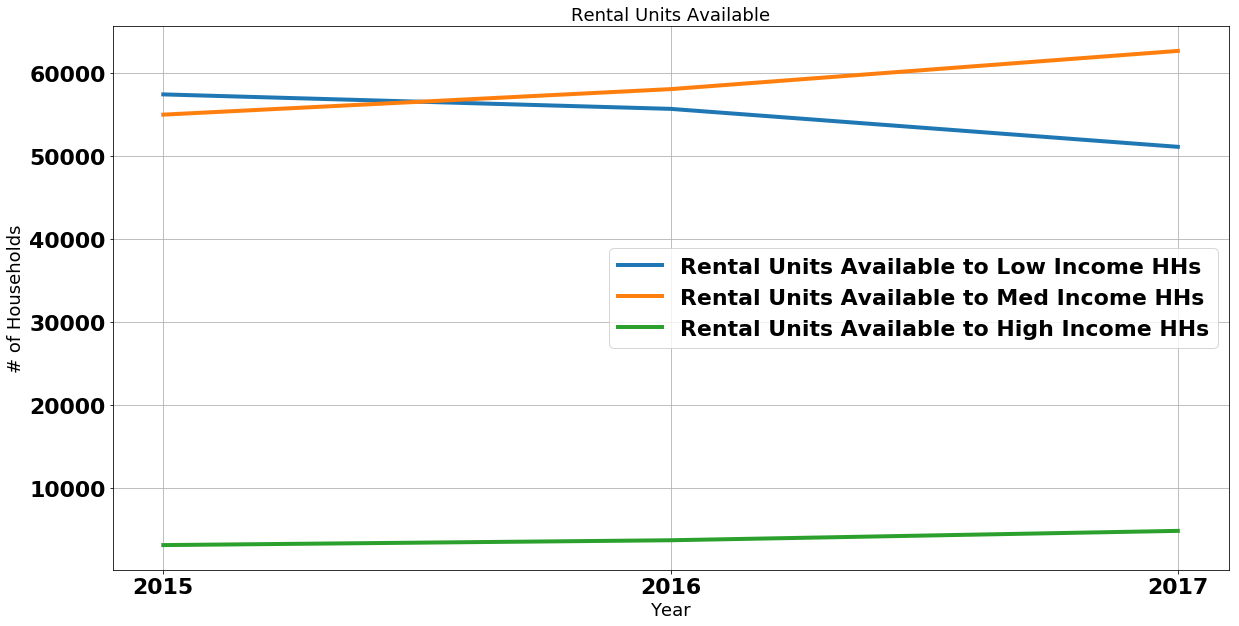

In [31]:
# Generate the Plot from percentrentbyincomesum for Total Households

# #Drop irrelevant data
# todrop = ['Less than 30.0 percent','Over 30.0 percent']
# hhsbyincome = percentrentbyincomesum.drop(axis=1, columns=todrop)


# Settings
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)



#Variables
colors = {'All Units 2015.0':'blue', 'All Units 2016.0':'blue', 'All Units 2017.0':'green'}
filename = 'Rental Units Available'
fig, ax = plt.subplots(figsize=(20, 10))
#Loop through all buckets
unitbuckets = allunitsonlysum.index.tolist()
for bucket in unitbuckets:

    print(bucket)

    y = allunitsonlysum.loc[bucket]
    x = ['2015','2016','2017']
    #print(percentbucket)
    plt.plot(x, y,color=colors.get(bucket), label=bucket,linewidth=4.0)

ax.legend()
ax.grid()
    # Create a title, x label, and y label for our chart

plt.title('Rental Units Available', fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylabel("# of Households", fontsize=18)


# Save the Figure
plt.savefig("images/" + filename + ".png")

#Display chart
plt.show()




In [21]:
print('Demand in each bracket')
display(hhsbyincome)

Demand in each bracket


Rent as % of Income    YEAR  TotalHHs
Income                               
Low Income           2015.0   48503.0
Moderate Income      2015.0   29509.0
High Income          2015.0   19675.0
Low Income           2016.0   48695.0
Moderate Income      2016.0   30753.0
High Income          2016.0   21171.0
Low Income           2017.0   46828.0
Moderate Income      2017.0   31893.0
High Income          2017.0   23213.0